In [ ]:
# Uncomment and run the below line to install yfinance
# Do this only once. Type "pip show yfinance" into terminal to check if it's already been installed. 
# The installation command can also be run in terminal

# pip install yfinance

In [10]:
# Importing libraries to use
import yfinance as yf
import pandas as pd
import os
from datetime import datetime, timedelta
from pytz import timezone
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [6]:
# Detect potential trading halts in minute data.
# Returns a list of potential halt times.
def detect_halt(data_minute):
    data_minute['Time Gap'] = data_minute.index.to_series().diff().fillna(pd.Timedelta(seconds=0))
    potential_halts = data_minute[data_minute['Time Gap'] > pd.Timedelta(minutes=1)]
    return potential_halts.index.tolist()

In [7]:
# Method to check if the ticker fulfills the halt condition:
# daily volume of 100,000 or higher that halt down. Then, when they re-open, 
# they conclude lower than the price of the stock when it was halted.
def check_halt_condition(stock_symbol, halt_price, resume_time, conclude_time, ticker_data):
    data = ticker_data[stock_symbol]

    # Check if resume_time and conclude_time are in data
    if resume_time not in data.index or conclude_time not in data.index:
        return False

    resume_price = data.at[resume_time, 'Open']
    conclude_price = data.at[conclude_time, 'Close']

    if halt_price > resume_price and conclude_price < halt_price:
        return True
    return False

In [15]:
datetime.now()

datetime.datetime(2023, 9, 17, 13, 53, 48, 454356)

In [18]:
# Checks and pulls data for all the relevant tickers
# Uses current date if you don't pass a specific date
def find_stocks(tickers, date=None):
    candidates = []
    ticker_data = {}

    eastern = timezone('US/Eastern')  # Assuming data is in Eastern Time, adjust as needed

    # If no date is passed, use today's date
    if date is None:
        date = datetime.now().date()

    for ticker in tickers:
        try:
            data_daily = yf.download(ticker, start=date, end=date + timedelta(days=1))
            if data_daily['Volume'][-1] >= 100000:
                data_minute = yf.download(ticker, interval="1m", start=date, end=date + timedelta(days=1))
                data_minute = data_minute.tz_convert(eastern)  # Convert to Eastern Time

                # Handle empty data
                if data_minute.empty:
                    print(f"No minute data for {ticker} on {date}.")
                    continue
                    
                ticker_data[ticker] = data_minute
                
                # Detect potential halts
                halt_times = detect_halt(data_minute)
                
                for halt_time in halt_times:
                    # For demonstration purposes, assume that trading resumes in the next available minute after the halt.
                    resume_time = data_minute.loc[halt_time:].index[1]
                    conclude_time = resume_time + pd.Timedelta(minutes=1)

                    halt_price = data_minute.at[halt_time, 'Close']

                    if check_halt_condition(ticker, halt_price, resume_time, conclude_time, ticker_data):
                        candidates.append(ticker)

                

        except Exception as e:
            print(f"Error processing {ticker}: {e}")

    return candidates, ticker_data

In [19]:
# Reads tickers entered line by line into a txt file
def read_tickers(filename):
    with open(filename,'r') as file:
        lines = [line.rstrip() for line in file]
    return lines

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Error processing SPGC: index 1 is out of bounds for axis 0 with size 1
Stocks to short: ['RETO', 'RETO', 'RETO', 'RETO', 'RETO', 'RETO', 'RETO', 'RETO', 'SPGC', 'SPGC', 'SPGC', 'SPGC', 'SPGC', 'SPGC', 'SPGC', 'SPGC', 'SPGC', 'SPGC', 'SPGC', 'SPGC', 'SPGC', 'SPGC', 'SPGC']
NBYMeets halt short condition. Data outputted to CSV
RETOMeets halt short condition. Data outputted to CSV
SPGCMeets halt short condition. Data outputted to CSV


<Figure size 720x432 with 0 Axes>

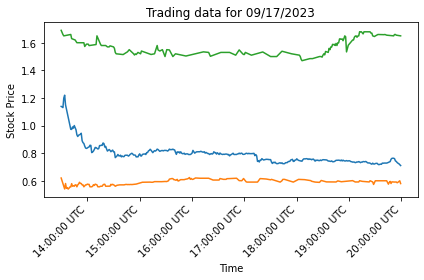

In [17]:
# This is the cell that makes the magic happen
# tickers = ['NBY', 'RETO','SPGC']  # Add tickers you are interested in
tickers=read_tickers('/Users/georgepandya/Desktop/Stock Strategies/StockStuff/tickers.txt') #Or Read from a file

date_to_check = datetime(2023, 9, 11).date()
result, all_data = find_stocks(tickers,date_to_check)

print(f"Stocks to short: {result}")

# Plot each of the relevant stocks into 
plt.figure(figsize=(10,6))
fig, ax = plt.subplots()

for ticker, df in all_data.items():
    # plt.plot(#df['Datetime'].strftime("%H:%M:%S"),
    #          df['Open'],label=ticker)
    df['Open'].plot(ax=ax,label=ticker)
    print(ticker+'Meets halt short condition. Data outputted to CSV')
    df.to_csv(ticker+'.csv')
# Format the plot
# fig, ax = plt.subplots()
# ax.plot(dates, values)

plt.title(f'Trading data for {datetime.now().date().strftime("%m/%d/%Y")}')
plt.xlabel('Time')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S %Z'))
plt.xticks(rotation=45)
plt.ylabel('Stock Price')
plt.legend
plt.tight_layout()
plt.show()